In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import optimizer

import matplotlib.pyplot as plt
pd.options.display.max_columns = None
pd.options.display.max_rows = 50
pd.options.display.min_rows = 20

%matplotlib notebook

In [2]:
crop_yield_data = pd.read_csv('yield_forecasting_database_0718.csv', parse_dates=['Date', ], dayfirst=True)
crop_yield_data = crop_yield_data.sort_values('Date')

In [3]:
crop_yield_data.keys()

Index(['Unnamed: 0', 'Vineyard_name', 'Block_name', 'Season', 'Date',
       'Variety', 'NDVImean', 'NDVIsum', 'NDWImean', 'NDWIsum', 'NDVIRemean',
       'NDVIResum', 'TCARImean', 'TCARIsum', 'SIPImean', 'SIPIsum',
       'RRENDVImean', 'RRENDVIsum', 'RN2NDVImean', 'RN2NDVIsum', 'GNDVImean',
       'GNDVIsum', 'MSRmean', 'MSRsum', 'RVImean', 'RVIsum', 'N2NDVImean',
       'N2NDVIsum', 'RENDVI1mean', 'RENDVI1sum', 'RENDVI2mean', 'RENDVI2sum',
       'RDVI1mean', 'RDVI1sum', 'RDVI2mean', 'RDVI2sum', 'TDVImean', 'TDVIsum',
       'TDVI2mean', 'TDVI2sum', 'NLImean', 'NLIsum', 'LAIGmean', 'LAIGsum',
       'SMmean', 'SMsum', 'GDD', 'Rainfall', 'Yield', 'Size', 'Ha',
       'SizeClass', 'TimeTo', 'BlockAverage', 'VineyardVarietyAverage',
       'HeatShock', 'FrostShock', 'MaxSize', 'PC1', 'PC2',
       'Cabernet Sauvignon', 'Chardonnay', 'Marzemino', 'Merlot', 'Pinot Gris',
       'Pinot Noir', 'Rare Red', 'Rare White', 'Riesling', 'Sauvignon Blanc',
       'Sauvignon Gris', 'Syrah', 'Yield

<IPython.core.display.Javascript object>


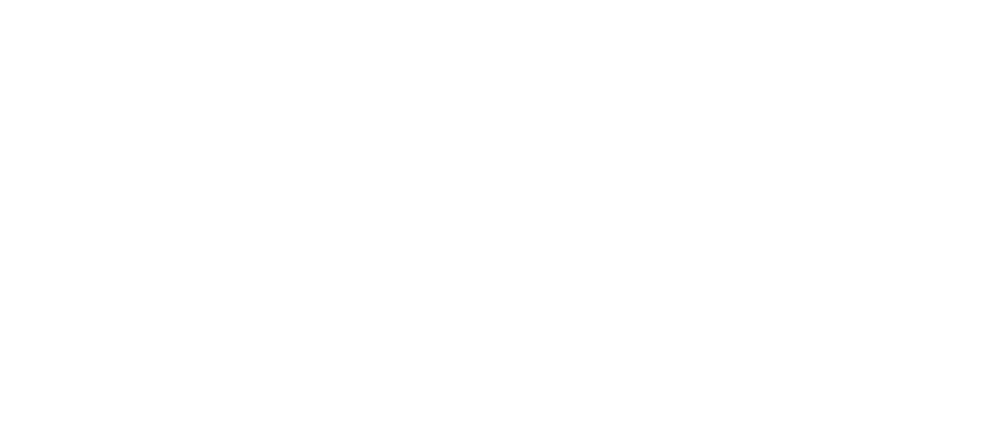

Text(0.5, 1.0, 'Data for one block')

In [4]:
%matplotlib notebook

data_block = crop_yield_data[crop_yield_data.Block_name == 'QB7WVWW'].sort_values('Date')

plt.figure(figsize=(9, 4))
plt.plot(data_block.Date.to_numpy(), data_block.GDD.to_numpy(), '*', label='GDD')
plt.plot(data_block.Date.to_numpy(), data_block.Rainfall.to_numpy(),  '*', label='Rainfall')

plt.plot(data_block.Date.to_numpy(), data_block.TimeTo.to_numpy(),  '*', label='TimeTo')
#plt.plot(data_block.Date.to_numpy(), data_block.NDWIsum.to_numpy(),  '*', label='NDWIsum')
plt.plot(data_block.Date.to_numpy(), data_block.FrostShock.to_numpy() * 100, '*', label='FrostShock')

plt.plot(data_block.Date.to_numpy(), data_block.Yield.to_numpy() * 10,  '*', label='Yield')

plt.legend()
plt.title('Data for one block')

## Cumulative quantities 

We define cumulative quantities over the season

In [5]:
def add_cumulative(data: pd.DataFrame, feature_name: str):
    cumulative_feature = crop_yield_data.groupby(['Season', 'Block_name'])[feature_name].cumsum()
    data['cml_' + feature_name] = cumulative_feature



In [6]:
cumulative_features = [
       # 'NDVImean', 'NDVIsum', 'NDWImean', 'NDWIsum', 'NDVIRemean',
       #'NDVIResum', 'TCARImean', 'TCARIsum', 'SIPImean', 'SIPIsum',
       #'RRENDVImean', 'RRENDVIsum', 'RN2NDVImean', 'RN2NDVIsum', 'GNDVImean',
       #'GNDVIsum', 'MSRmean', 'MSRsum', 'RVImean', 'RVIsum', 'N2NDVImean',
       #'N2NDVIsum', 'RENDVI1mean', 'RENDVI1sum', 'RENDVI2mean', 'RENDVI2sum',
       #'RDVI1mean', 'RDVI1sum', 'RDVI2mean', 'RDVI2sum', 'TDVImean', 'TDVIsum',
       #'TDVI2mean', 'TDVI2sum', 'NLImean', 'NLIsum', 'LAIGmean', 'LAIGsum',
       #'SMmean', 'SMsum', 
        #'GDD', 'Rainfall'
]

for feature in cumulative_features:
    add_cumulative(crop_yield_data, feature)

## Basic model 

In [7]:
N_EPOCHS = 100
BATCH_SIZE = 512
DEVICE = 'cuda:0'

For our first model we will only use a handfull of features, specifically:
1. GDD: this indicator is related to the amount of sun
2. Rainfall: indicator for the amount of rain
3. TimeTo: time until harvesting
4. HeatShock, Frostshock: indicators of temperature shocks
5. High yield / Low yield: important feature as it determines the method of growth

In [8]:
feature_names = ['GDD', 'Rainfall', 'High yield',
                 'TimeTo', 
                 #
                 #'FrostShock', 'HeatShock',
                'MaxSize',
                'NDVImean', 'NDVIsum', 'NDWImean', 'NDWIsum', 'NDVIRemean',
               'NDVIResum', 'TCARImean', 'TCARIsum', 'SIPImean', 'SIPIsum',
               'RRENDVImean', 'RRENDVIsum', 'RN2NDVImean', 'RN2NDVIsum', 'GNDVImean',
               'GNDVIsum', 'MSRmean', 'MSRsum', 'RVImean', 'RVIsum', 'N2NDVImean',
               'N2NDVIsum', 'RENDVI1mean', 'RENDVI1sum', 'RENDVI2mean', 'RENDVI2sum',
               'RDVI1mean', 'RDVI1sum', 'RDVI2mean', 'RDVI2sum', 'TDVImean', 'TDVIsum',
               'TDVI2mean', 'TDVI2sum', 'NLImean', 'NLIsum', 'LAIGmean', 'LAIGsum',
               'SMmean', 'SMsum',
                'Cabernet Sauvignon', 'Chardonnay', 'Marzemino', 'Merlot', 'Pinot Gris',
                'Pinot Noir', 'Rare Red', 'Riesling', 'Sauvignon Blanc', 'Sauvignon Gris',
                'Syrah',
                ]

feature_names.extend(['_'.join(('cml', f_name)) for f_name in cumulative_features])
print(feature_names)

['GDD', 'Rainfall', 'High yield', 'TimeTo', 'MaxSize', 'NDVImean', 'NDVIsum', 'NDWImean', 'NDWIsum', 'NDVIRemean', 'NDVIResum', 'TCARImean', 'TCARIsum', 'SIPImean', 'SIPIsum', 'RRENDVImean', 'RRENDVIsum', 'RN2NDVImean', 'RN2NDVIsum', 'GNDVImean', 'GNDVIsum', 'MSRmean', 'MSRsum', 'RVImean', 'RVIsum', 'N2NDVImean', 'N2NDVIsum', 'RENDVI1mean', 'RENDVI1sum', 'RENDVI2mean', 'RENDVI2sum', 'RDVI1mean', 'RDVI1sum', 'RDVI2mean', 'RDVI2sum', 'TDVImean', 'TDVIsum', 'TDVI2mean', 'TDVI2sum', 'NLImean', 'NLIsum', 'LAIGmean', 'LAIGsum', 'SMmean', 'SMsum', 'Cabernet Sauvignon', 'Chardonnay', 'Marzemino', 'Merlot', 'Pinot Gris', 'Pinot Noir', 'Rare Red', 'Riesling', 'Sauvignon Blanc', 'Sauvignon Gris', 'Syrah']


In [9]:
crop_yield_data['YieldPerHec_log'] = np.log(crop_yield_data.YieldPerHec)
crop_yield_data['YieldPerHec_log_n'] = (crop_yield_data.YieldPerHec_log - crop_yield_data.YieldPerHec_log.mean()) / crop_yield_data.YieldPerHec_log.std()

In [10]:
crop_yield_data.FrostShock = crop_yield_data.FrostShock.fillna(-5)
crop_yield_data.HeatShock = crop_yield_data.HeatShock.fillna(-5)

In [11]:
from typing import List
from datetime import datetime
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from tukey.losses import TuckeyGandHloss

def convert_dataset_to_tensor(pd_data: pd.DataFrame, feature_names: List[str], target_name: str,
                             log_target: bool = True, mean_features: float = None,
                              std_features: float = None):
    features = pd_data[feature_names]
    targets = pd_data[target_name]
    features_torch = torch.from_numpy(features.to_numpy()).to(dtype=torch.float32)
    targets_torch = torch.from_numpy(targets.to_numpy()).to(dtype=torch.float32)
    # apply transformations
    if log_target:
        targets_torch = torch.log(targets_torch)
    else:
        pass
        #targets_torch = (targets_torch - 200) / 100
    targets_torch = torch.reshape(targets_torch, ((-1, 1)))
    
    # compute mean and std for training data
    if mean_features is None:
        mean = torch.mean(features_torch, dim=0, keepdim=True)
        std = torch.std(features_torch, dim=0, keepdim=True)
        features_torch = (features_torch - mean) / std
        return (features_torch, targets_torch), (mean, std)
    # for new data apply mean and std from train data
    features_torch = (features_torch - mean_features) / std_features
    return features_torch, targets_torch


def split_train_test(pd_data: pd.DataFrame, split_date: str):
    split_date = datetime.fromisoformat(split_date)
    train, test = pd_data[pd_data.Date <= split_date], pd_data[pd_data.Date > split_date]
    return train, test


class NN(Sequential):
    def __init__(self, structure: list, n_out: int):
        subblocks = []
        self.n_out = n_out
        for i in range(len(structure) - 1):
            subblocks.extend(self._make_sublock(structure[i], structure[i + 1]))
        subblocks.extend(self._make_final_layer(structure[-1]))
        super().__init__(*subblocks)

    def _make_sublock(self, n_in: int, n_out: int):
        return [Linear(n_in, n_out), ReLU()]#, BatchNorm1d(n_out)]

    def _make_final_layer(self, n_in : int):
        return [Linear(n_in, self.n_out), ]


def train_for_one_epoch(nn, loss, optimizer, scheduler, train_dataset: Dataset, val_dataset: Dataset):
    nn.train()
    dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    losses = []
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = nn(x)
        loss_y_yhat = loss(y_hat, y)
        loss_y_yhat.backward()
        optimizer.step()
        losses.append(loss_y_yhat.detach().item())
    scheduler.step()
    print('Train losses: ', np.mean(losses))
    
    nn.eval()
    dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    losses = []
    losses_gaussian = []
    with torch.no_grad():
        for x, y in dataloader_val:
            y_hat = nn(x)
            loss_y_yhat = loss(y_hat, y)
            losses.append(loss_y_yhat.detach().item())
    print('Validation losses: ', np.mean(losses))

In [12]:
train = crop_yield_data[crop_yield_data.Season < 2020]
test = crop_yield_data[crop_yield_data.Season == 2020]

train_torch, mean_std = convert_dataset_to_tensor(train, feature_names, 'YieldPerHec_log', False)
test_torch = convert_dataset_to_tensor(test, feature_names, 'YieldPerHec_log', False, *mean_std)

train_torch[0].shape, train_torch[1].shape

(torch.Size([26926, 56]), torch.Size([26926, 1]))

In [13]:
from torch.optim import Adam, SGD
nn = NN((len(feature_names), 32, 128, 128, 64, 32, 32), 4)  # 4 outputs required for G-and-H

In [14]:
from torch.optim.lr_scheduler import StepLR, CyclicLR
optimizer = Adam(nn.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=25)
#scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=10)


In [15]:
torch.any(torch.isnan(train_torch[0]))

tensor(False)

Train losses:  1.3560385257005692
Validation losses:  0.14430147714235567


<IPython.core.display.Javascript object>


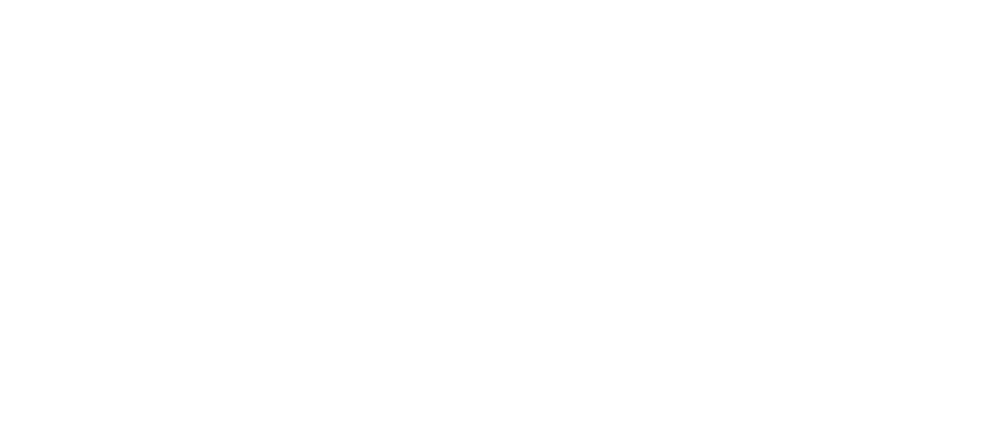

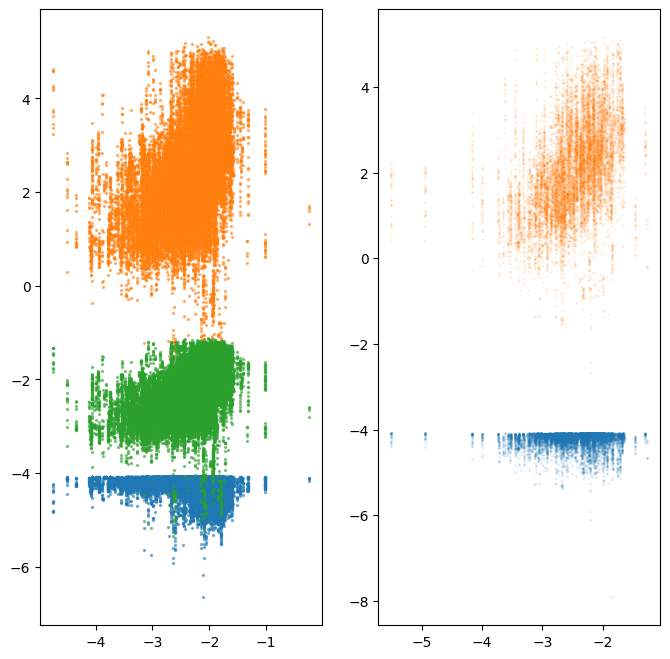

Train losses:  -0.28712681193764394
Validation losses:  -0.3437030545689843


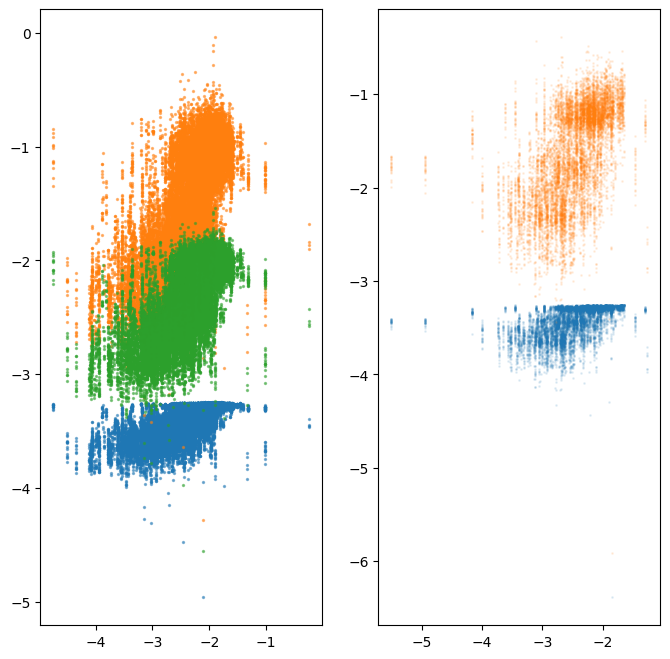

Train losses:  -0.517532294186262
Validation losses:  -0.34109194250777364


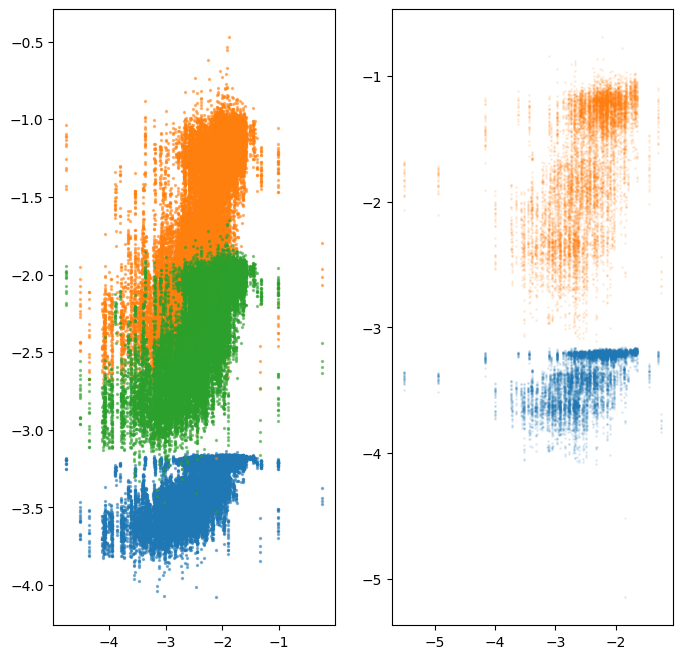

Train losses:  -0.5441134738234373
Validation losses:  -0.32253832437775354


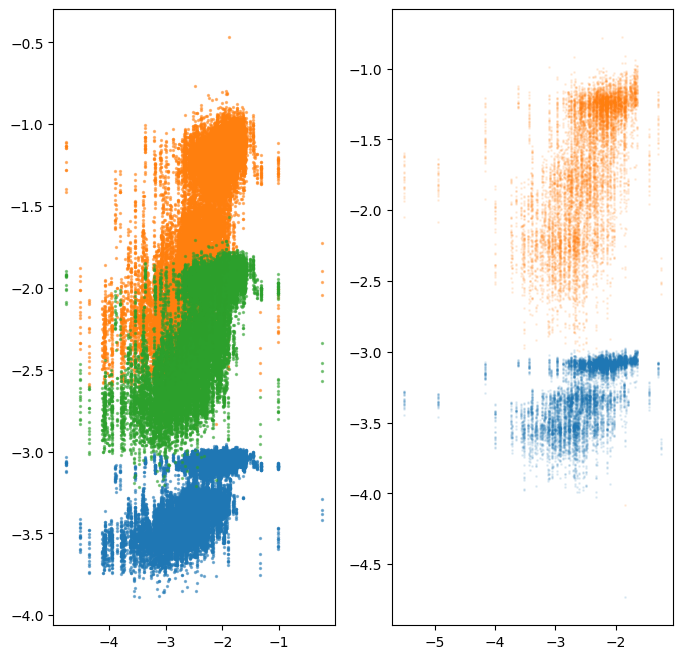

Train losses:  -0.5690994990559725
Validation losses:  -0.3710484132170677


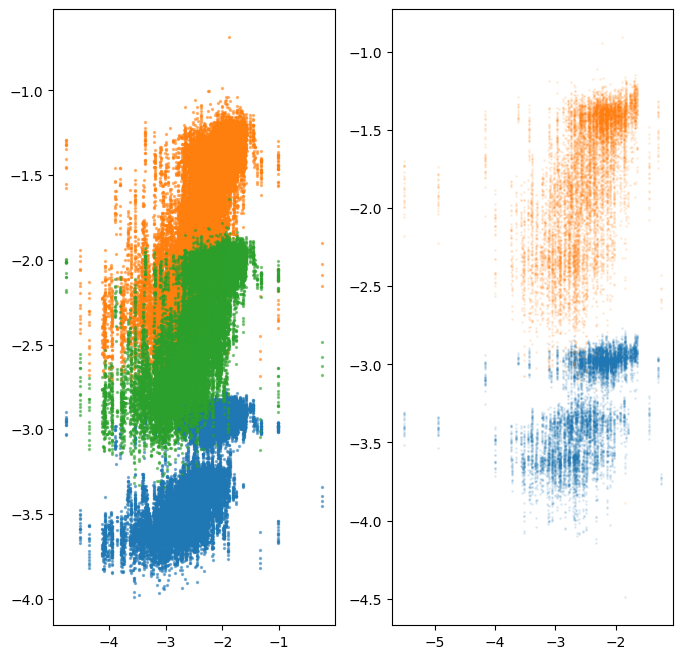

Train losses:  -0.6169458066041653
Validation losses:  -0.39275150475176895


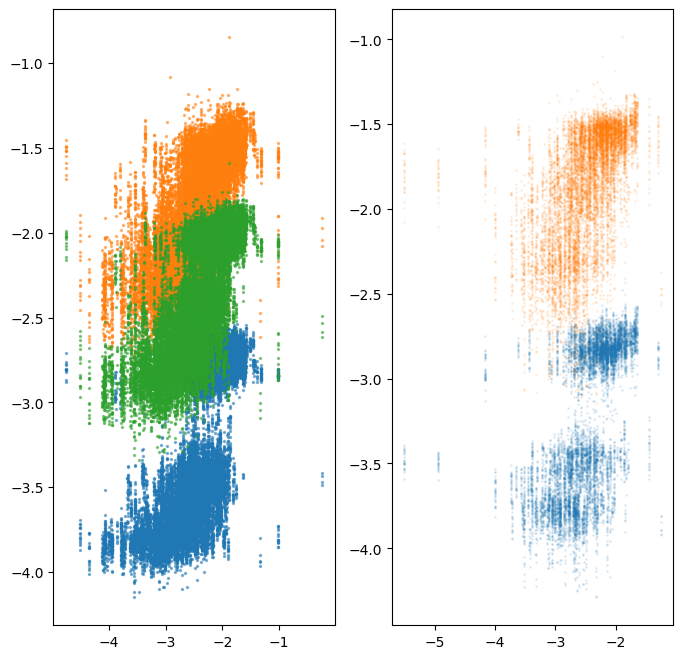

Train losses:  -0.6473743755083817
Validation losses:  -0.376720877872272


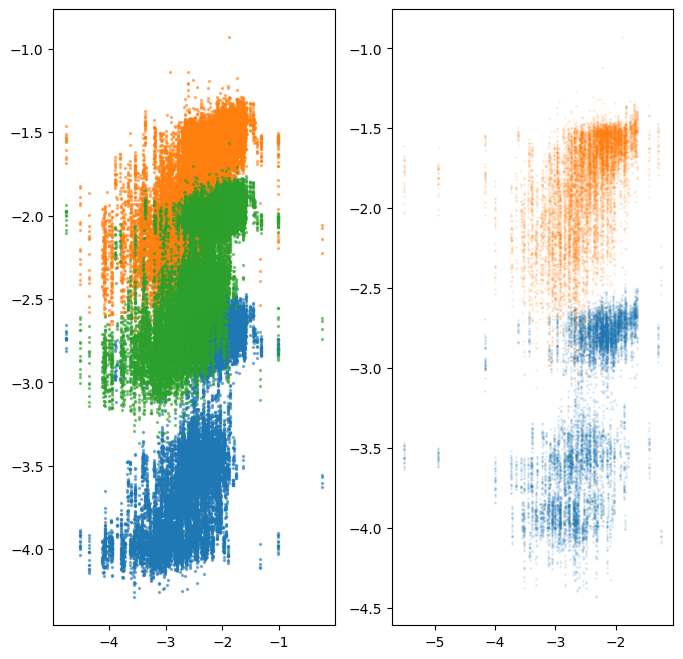

Train losses:  -0.6610728869071374
Validation losses:  -0.3575118576938456


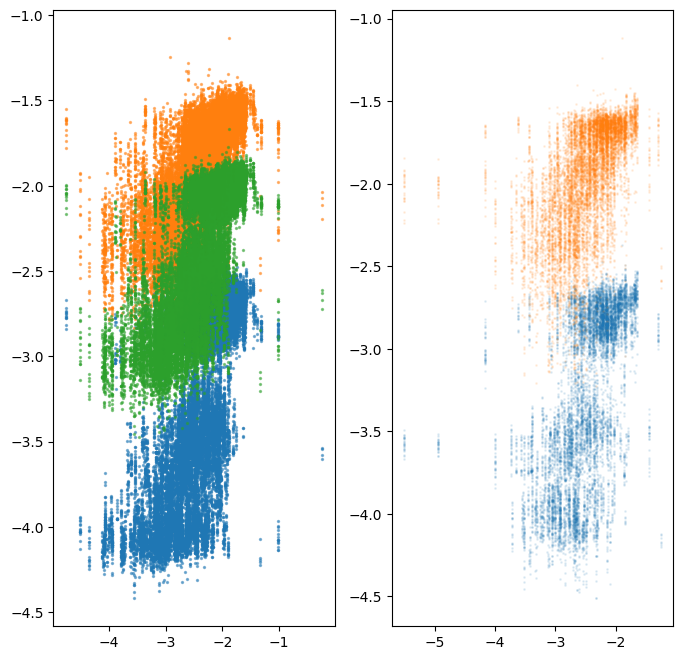

Train losses:  -0.6721916439441534
Validation losses:  -0.35744503055783833


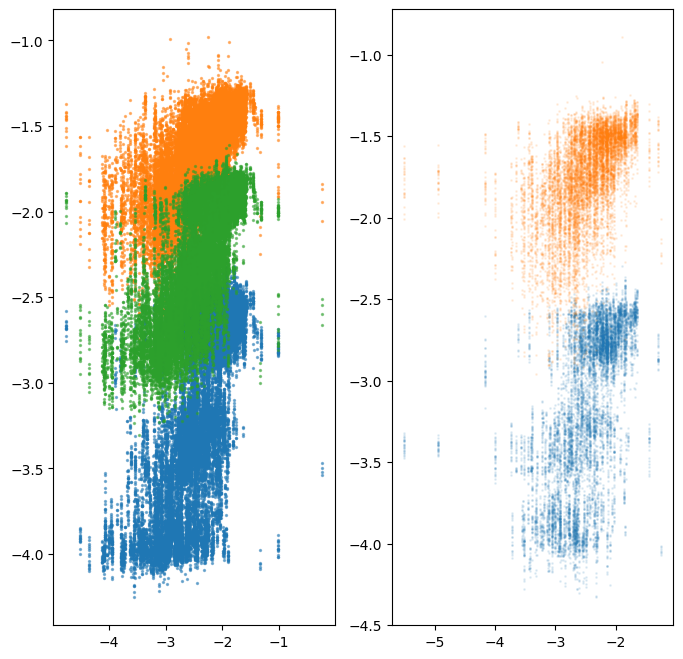

Train losses:  -0.6804872235426536
Validation losses:  -0.37142612040042877


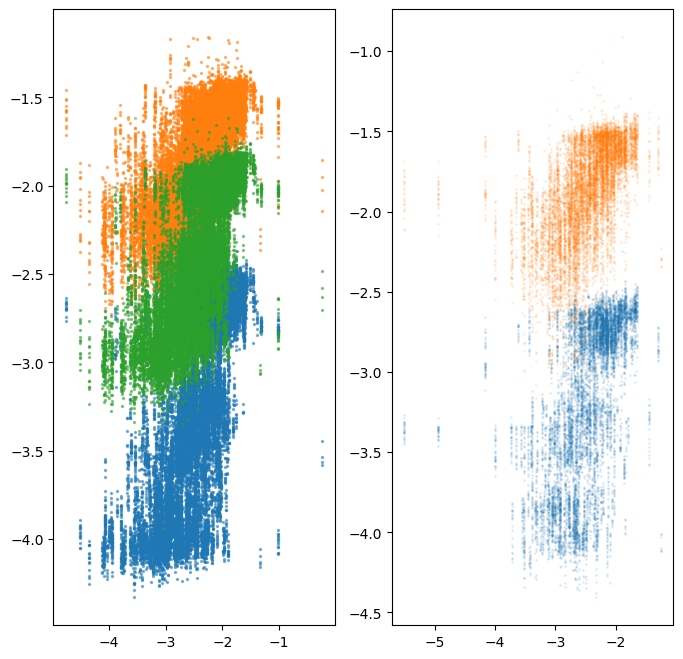

Train losses:  -0.6881073954013678
Validation losses:  -0.33570568737658585


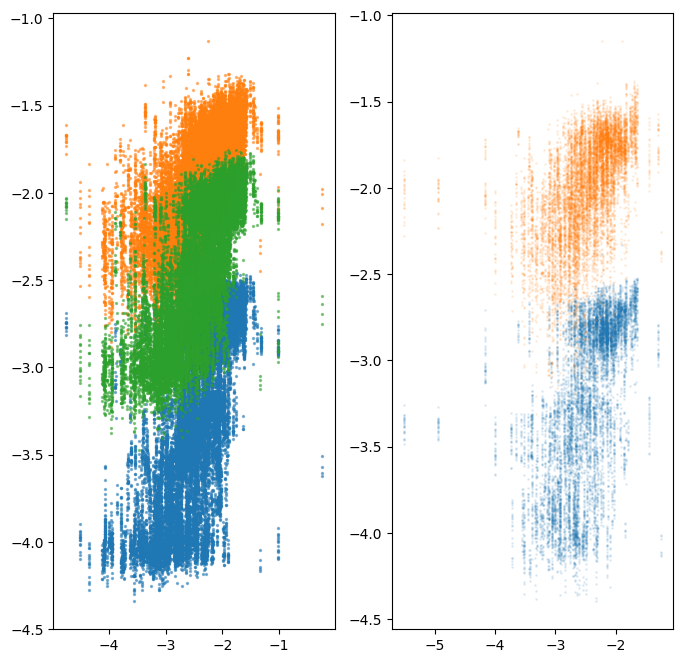

Train losses:  -0.6951886358169409
Validation losses:  -0.36743021045218816


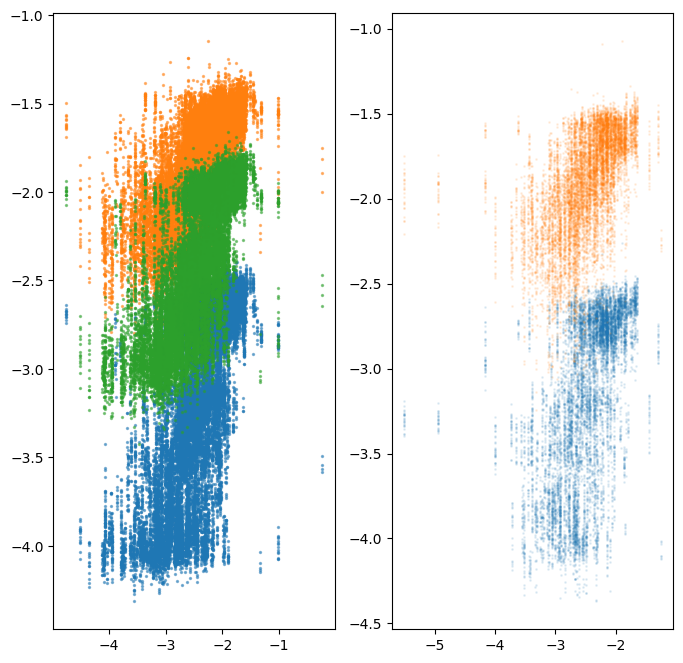

Train losses:  -0.6916364981577947
Validation losses:  -0.35673092237927695


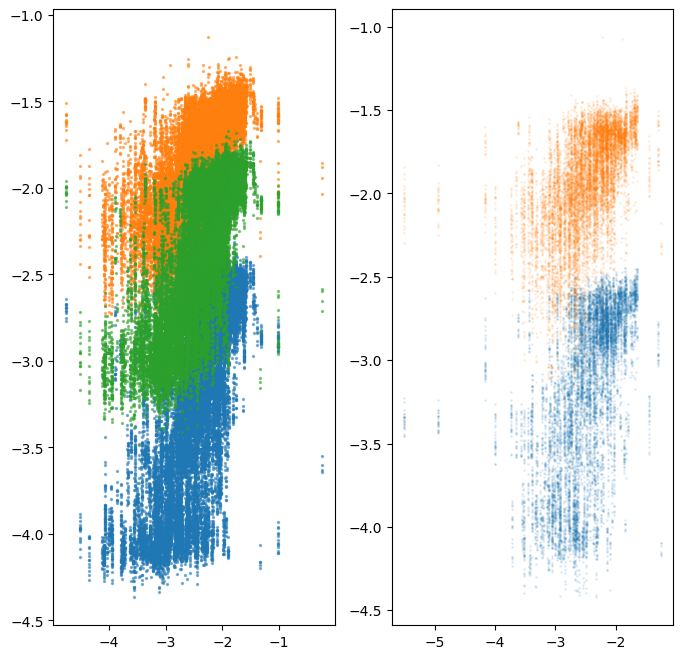

Train losses:  -0.6975495310930105
Validation losses:  -0.33814502507448196


KeyboardInterrupt: 

In [16]:
%matplotlib inline

loss = TuckeyGandHloss(n_target_channels=1, gmax=1, hmax=1)

nn = nn.to(device=DEVICE)
train_torch = tuple([v.to(device=DEVICE) for v in train_torch])
test_torch = tuple([v.to(device=DEVICE) for v in test_torch])


for i_epoch in range(N_EPOCHS):
    epoch_loss = train_for_one_epoch(nn, loss, optimizer, scheduler,
                                     TensorDataset(*train_torch), TensorDataset(*test_torch))
    nn.eval()
    fig = plt.figure(figsize=(8, 8))
    with torch.no_grad():
        y_train = nn(train_torch[0])
        pred_ci95 = loss.predict_ci(y_train)
        pred_ci001 = loss.predict_ci(y_train, alpha=0.001)
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(train_torch[1].cpu(), pred_ci95[0].cpu(), alpha=0.5, s=2)
    ax.scatter(train_torch[1].cpu(), pred_ci95[1].cpu(), alpha=0.5, s=2)
    ax.scatter(train_torch[1].cpu(), pred_ci001[1].cpu(), alpha=0.5, s=2)
    with torch.no_grad():
        pred_ci95 = loss.predict_ci(nn(test_torch[0]))
    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(test_torch[1].cpu(), pred_ci95[0].cpu(), alpha=0.1, s=1)
    ax.scatter(test_torch[1].cpu(), pred_ci95[1].cpu(), alpha=0.1, s=1)
    plt.show()
    plt.pause(0.1)


Now we look at some predictions on the validation dataset

In [50]:
%matplotlib notebook

def plot_specific_block(block_name: str):
    data_block = test[test.Block_name == block_name].sort_values('Date')
    features_torch, targets_torch = convert_dataset_to_tensor(data_block, feature_names, 'YieldPerHec_log_n', 
                                                              True, *mean_std)
    nn.eval()
    with torch.no_grad():
        y_hat = nn(features_torch.to(device=DEVICE))
    ci = loss.predict_ci(y_hat, alpha=0.95)
    ci2 = loss.predict_ci(y_hat, alpha=0.99)
    ci3 = loss.predict_ci(y_hat, alpha=0.25)
    plt.figure()
    plt.plot(data_block.Date, np.exp(ci[0].cpu().numpy()), 'k', label='95% level')
    plt.plot(data_block.Date, np.exp(ci[1].cpu().numpy()), 'k')
    plt.plot(data_block.Date, np.exp(ci2[0].cpu().numpy()), 'r', label='99% level')
    plt.plot(data_block.Date, np.exp(ci2[1].cpu().numpy()), 'r')
    plt.plot(data_block.Date, np.exp(ci3[0].cpu().numpy()), 'b')
    plt.plot(data_block.Date, np.exp(ci3[1].cpu().numpy()), 'b', label='25% level')
    plt.scatter(data_block.Date.values[-1], data_block.YieldPerHec.values[-1], marker='*', c='g', s=50)
    plt.legend()
    plt.ylabel('Yield Per Hec')
    plt.title(f'Block {block_name}')

<IPython.core.display.Javascript object>


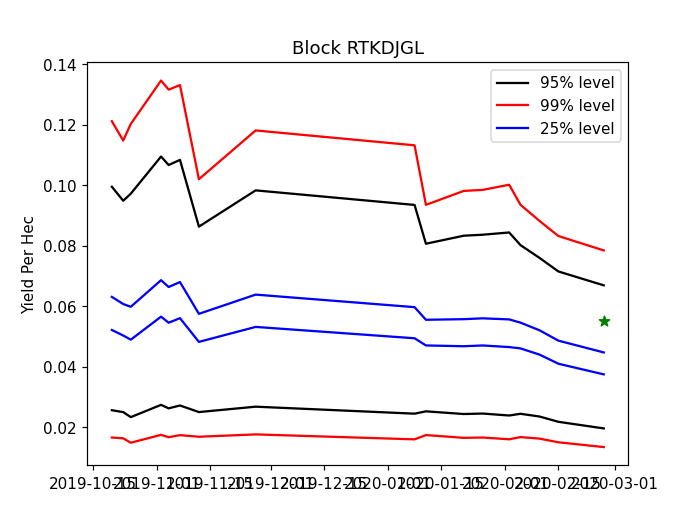

<IPython.core.display.Javascript object>


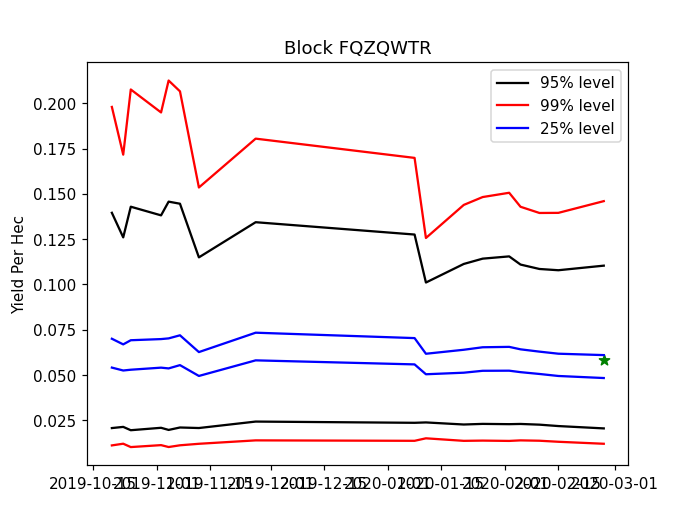

<IPython.core.display.Javascript object>


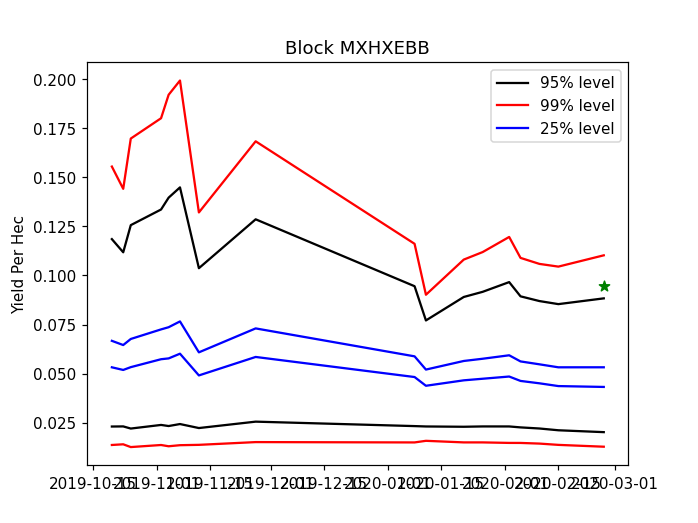

<IPython.core.display.Javascript object>


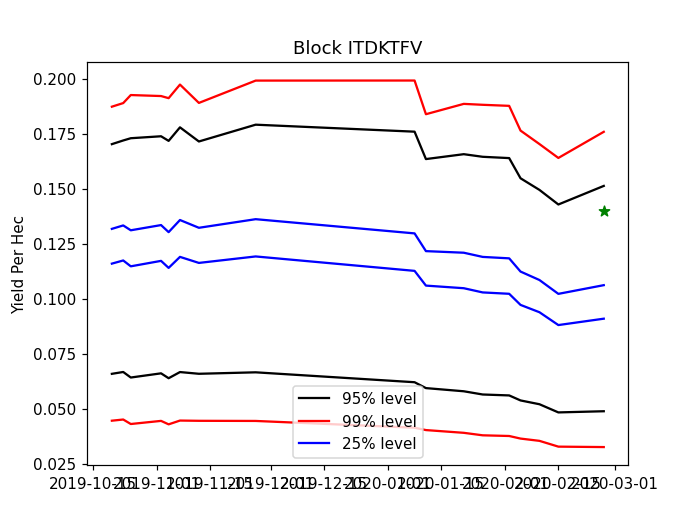

<IPython.core.display.Javascript object>


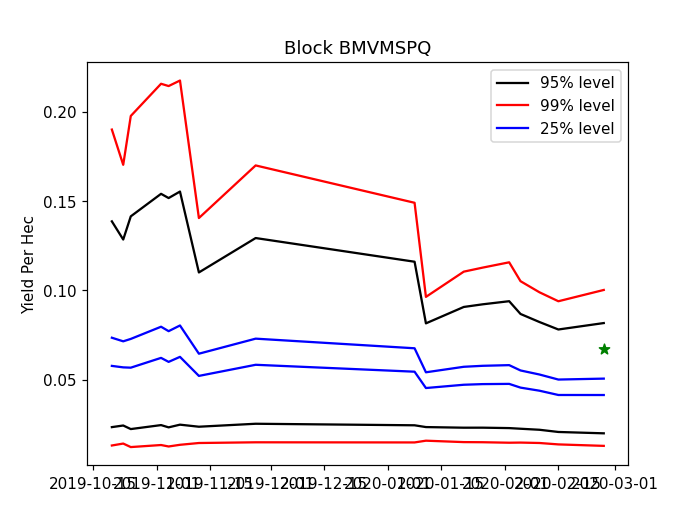

<IPython.core.display.Javascript object>


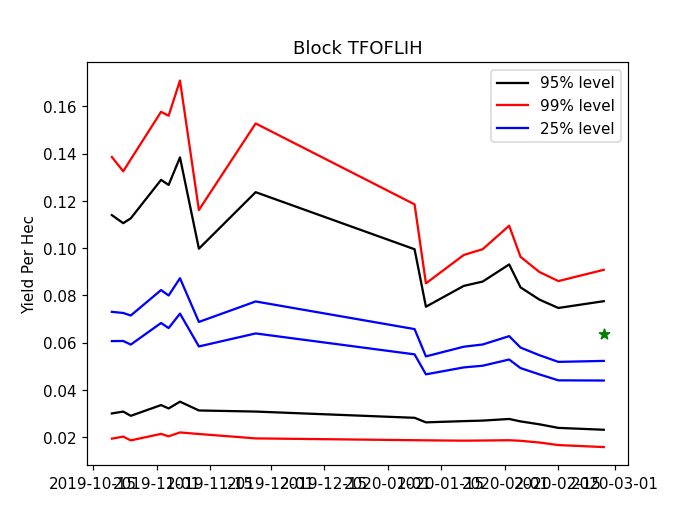

<IPython.core.display.Javascript object>


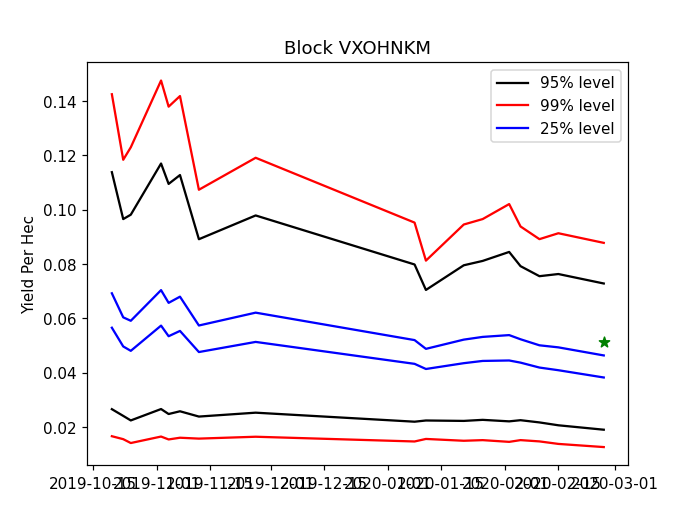

<IPython.core.display.Javascript object>


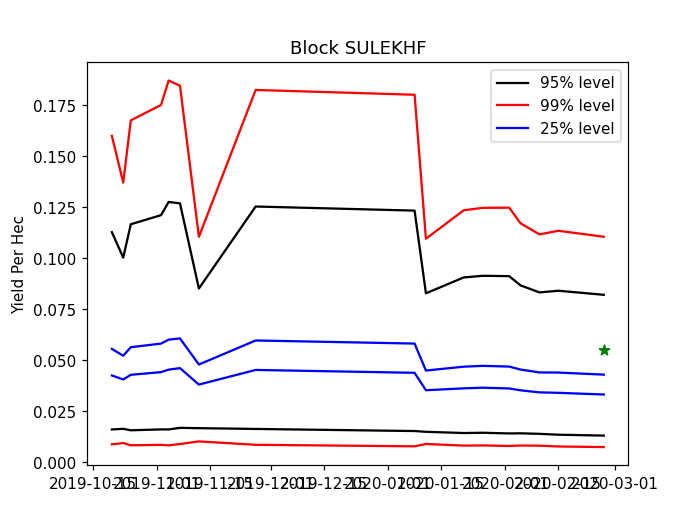

<IPython.core.display.Javascript object>


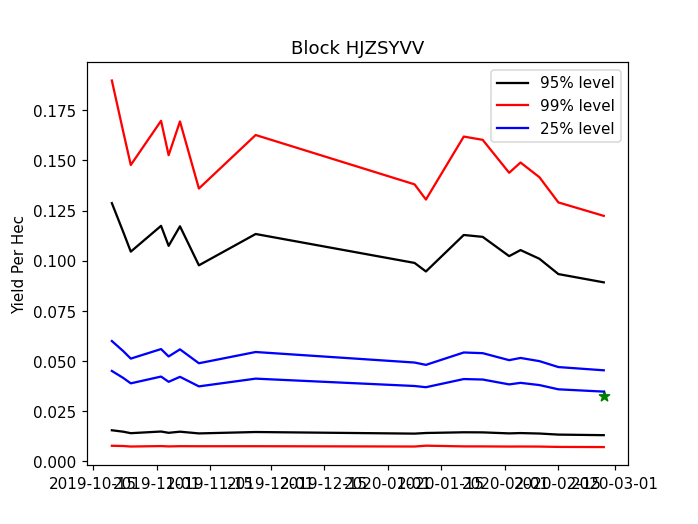

<IPython.core.display.Javascript object>


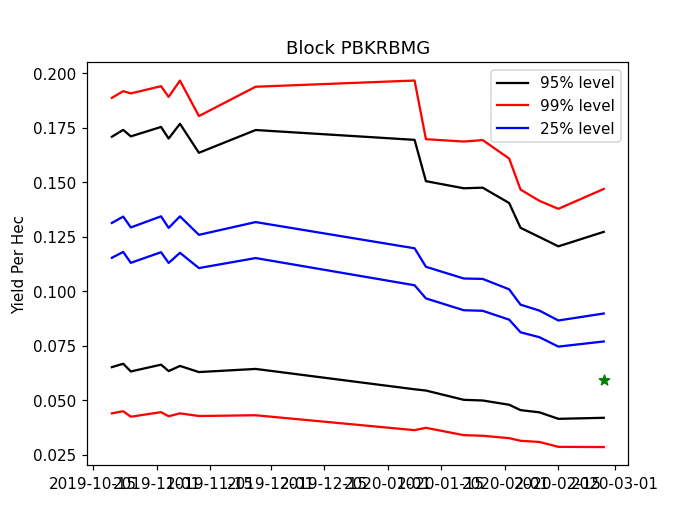

<IPython.core.display.Javascript object>


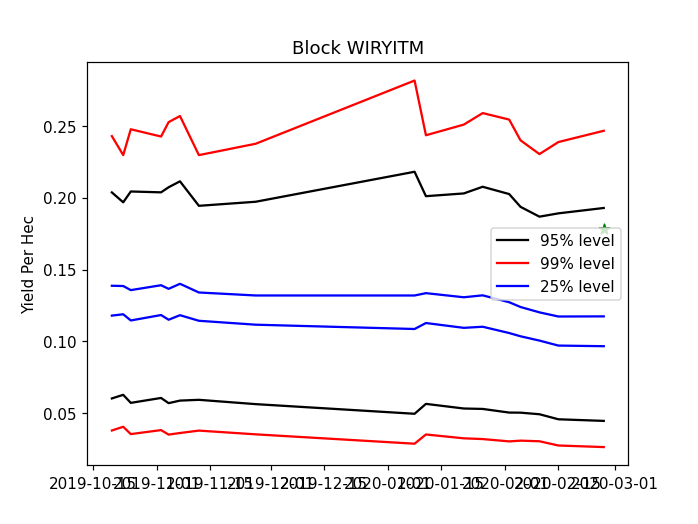

<IPython.core.display.Javascript object>


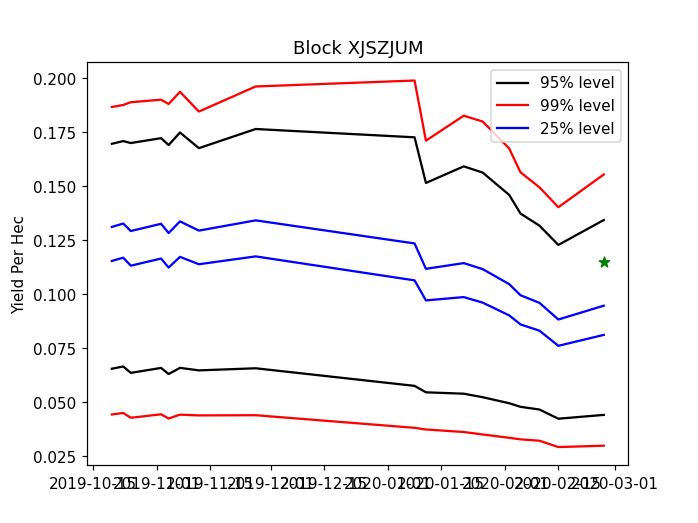

<IPython.core.display.Javascript object>


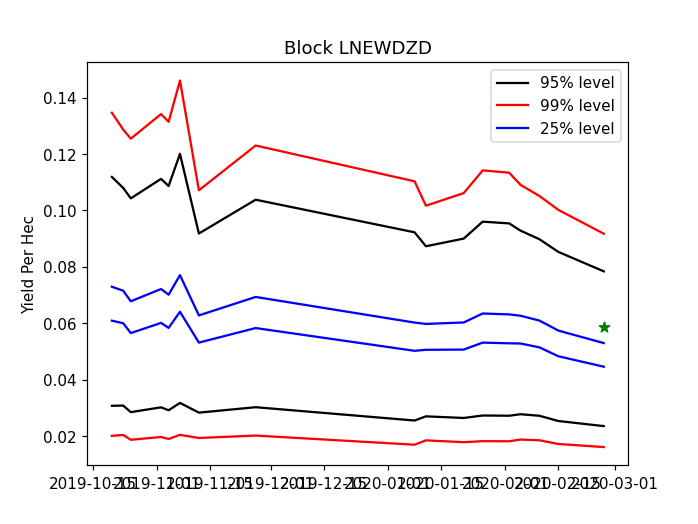

<IPython.core.display.Javascript object>


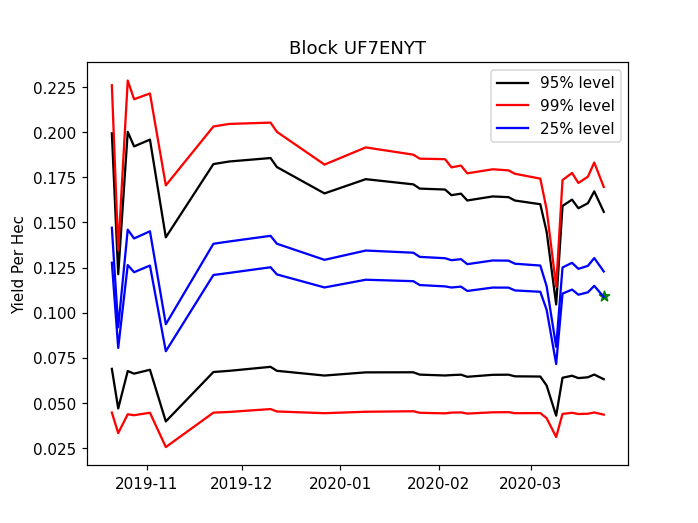

<IPython.core.display.Javascript object>


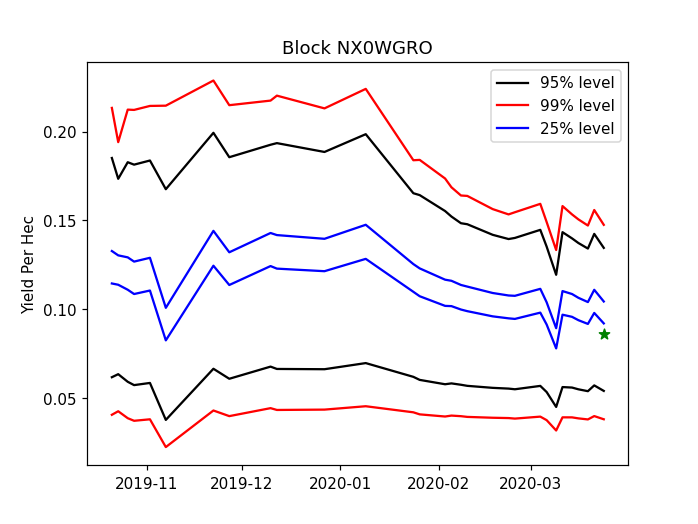

<IPython.core.display.Javascript object>


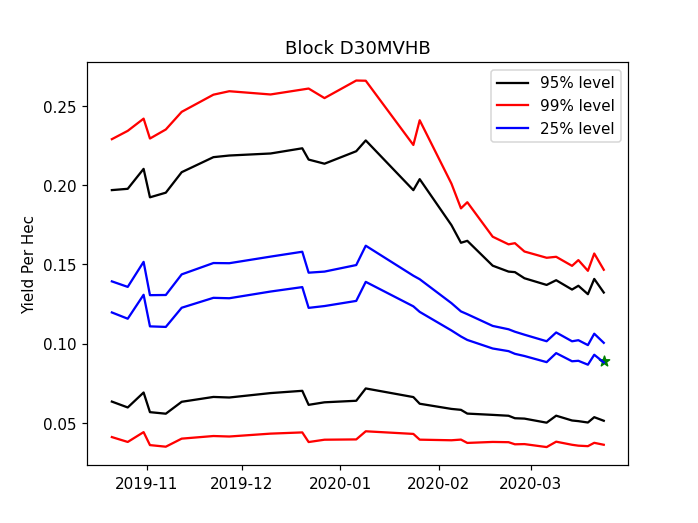

<IPython.core.display.Javascript object>


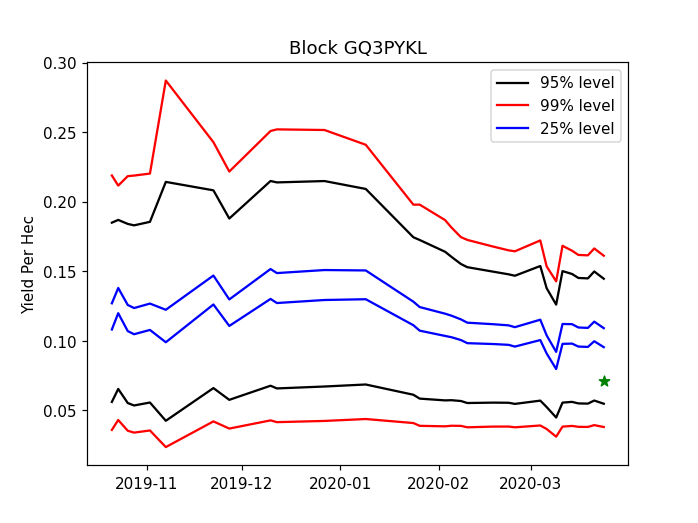

<IPython.core.display.Javascript object>


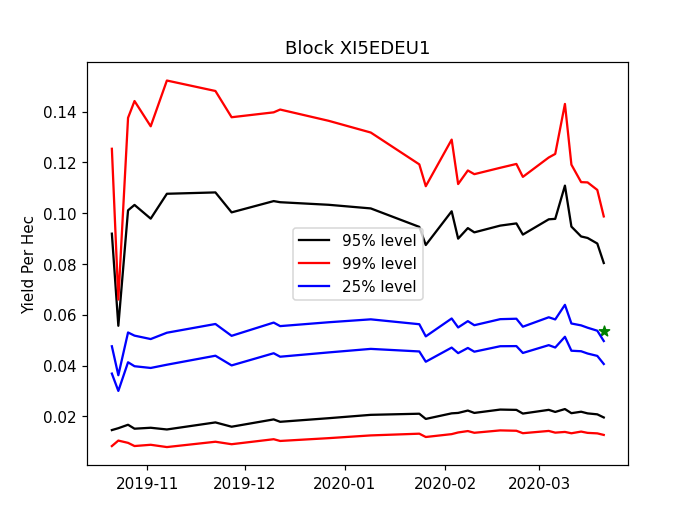

<IPython.core.display.Javascript object>


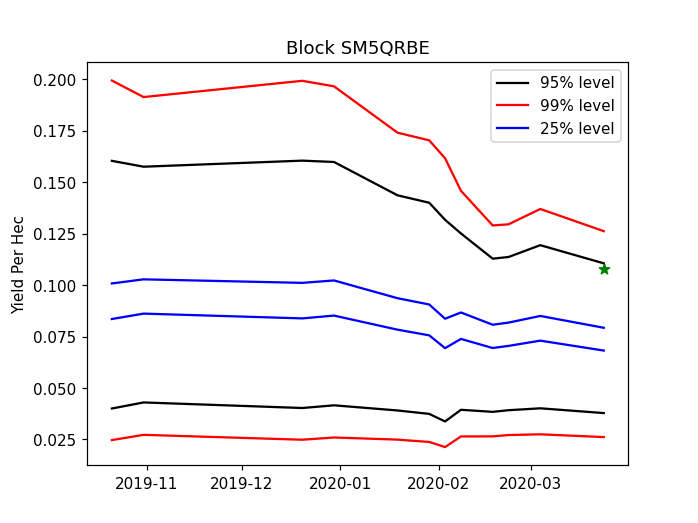

<IPython.core.display.Javascript object>


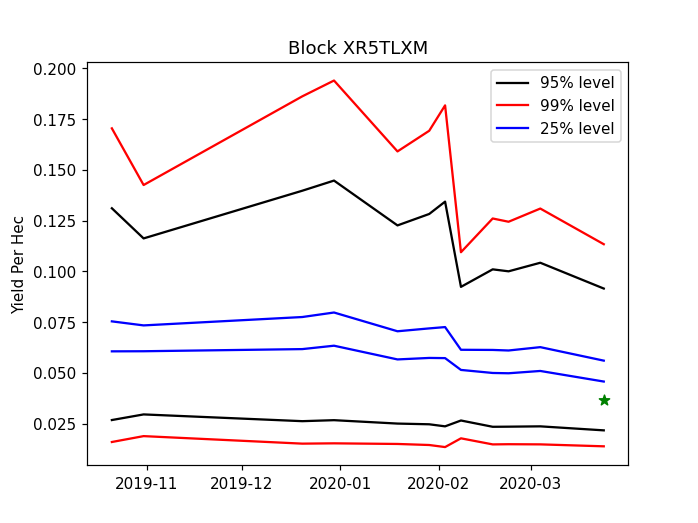

In [51]:
sel = crop_yield_data.Season == 2020
sel = np.logical_and(sel,  crop_yield_data.YieldPerHec)
for block_name in crop_yield_data[sel].Block_name[20:40]:
    plot_specific_block(block_name)

### Plot of residuals 

In [17]:
train = train.reset_index()
test = test.reset_index()

In [24]:
sel = train.index[train.TimeTo < 60].to_numpy()
sel_test = test.index[test.TimeTo < 60].to_numpy()

In [25]:
with torch.no_grad():
    pred_train = nn(train_torch[0][sel, :])
    pred_test = nn(test_torch[0][sel_test, :])
residuals_train = loss.residuals(pred_train, train_torch[1][sel, :]).cpu().numpy()
residuals_test = loss.residuals(pred_test, test_torch[1][sel_test, :]).cpu().numpy()

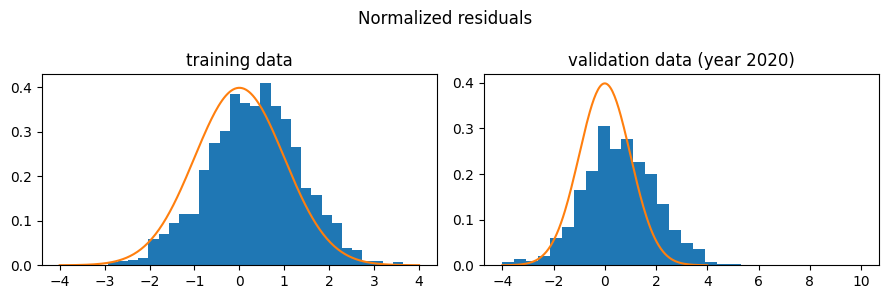

In [27]:
from scipy.stats import norm
xs = np.linspace(-4, 4, 200)
ys = norm.pdf(xs)

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 2, 1)
ax.hist(residuals_train, bins=30, density=True)
ax.plot(xs, ys)
ax.set_title('training data')
ax = fig.add_subplot(1, 2, 2)
ax.hist(residuals_test, bins=30, density=True)
ax.plot(xs, ys)
ax.set_title('validation data (year 2020)')
fig.suptitle('Normalized residuals')
fig.tight_layout()



### Plot of some predictions